In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [78]:
POINTS_IN_BLOB = 50

MIN_OFFSET = -100
MAX_OFFSET = 100

MIN_SHIFT = -100
MAX_SHIFT = 100

MIN_BLOB_STD = 5
MAX_BLOB_STD = 40

def random_number(_min, _max):
    return np.random.random() * (_max - _min) + _min

def get_blob_center():
    offset = random_number(MIN_OFFSET, MAX_OFFSET)
    return offset + random_number(MIN_SHIFT, MAX_SHIFT), offset + random_number(MIN_SHIFT, MAX_SHIFT)

def get_blob_std():
    return random_number(MIN_BLOB_STD, MAX_BLOB_STD)

def get_blob(class_index):
    coords, classes = make_blobs(n_samples=POINTS_IN_BLOB, centers=[get_blob_center()], n_features=2, cluster_std=get_blob_std())
    return coords, np.full(classes.shape, class_index)

def get_dataset(class_count, blobs_per_class):
    coords = np.empty(shape=(0, 2))
    classes = np.empty(shape=(0, 1))

    for i in range(class_count):
        for j in range(blobs_per_class):
            new_coords, new_classes = get_blob(i)
            coords = np.append(coords, new_coords, axis=0)
            classes = np.append(classes, new_classes)

    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(coords[:,0], coords[:,1], c=classes, cmap=plt.cm.RdBu, edgecolors='k')

    return coords, classes


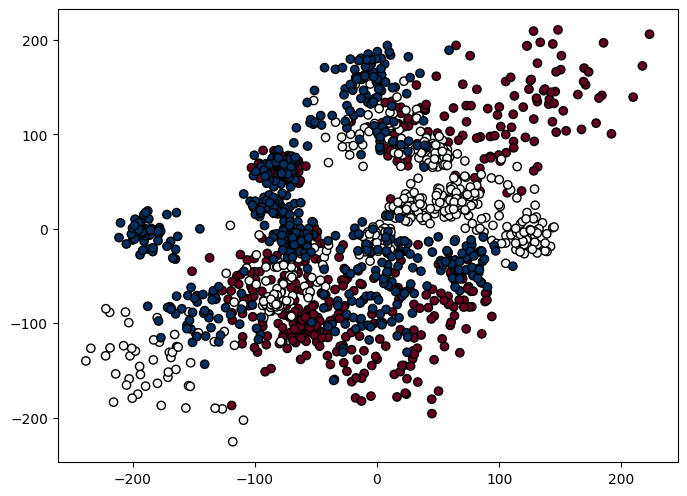

In [89]:
X, y = get_dataset(3, 10)

In [106]:
def train(X_train, y_train, k, weights, metric):
    metric_params = {'V': np.cov(X_train.T)} if metric == 'mahalanobis' else None
    neigh = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric, metric_params=metric_params)
    neigh.fit(X_train, y_train)
    return neigh

In [99]:
def train_with_params(X_train, y_train, k, weights = "uniform", metric = "minkowski"):
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5

    mesh_step = 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step), np.arange(y_min, y_max, mesh_step))

    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')

    neigh = train(X_train, y_train, k, weights, metric)

    predicted_classes = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
    predicted_classes = predicted_classes.reshape(xx.shape)

    plt.contourf(xx, yy, predicted_classes, cmap=plt.cm.RdBu, alpha=0.8)


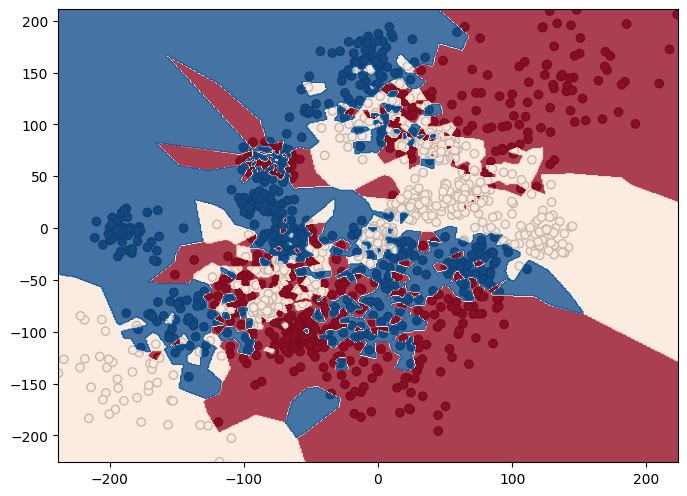

In [113]:
train_with_params(X, y, 1)

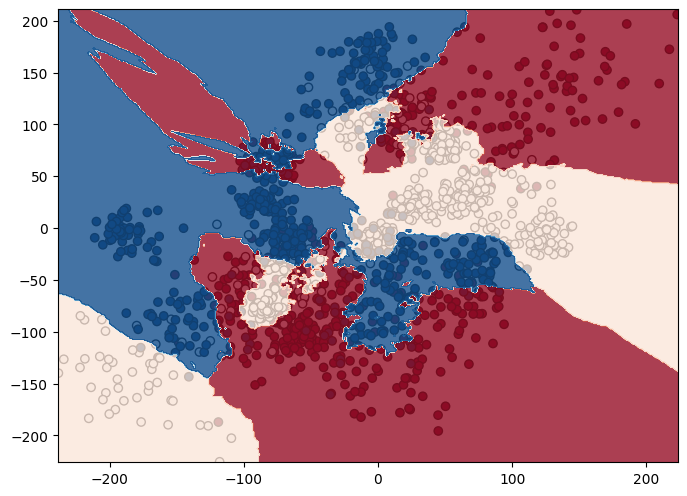

In [112]:
train_with_params(X, y, 13)

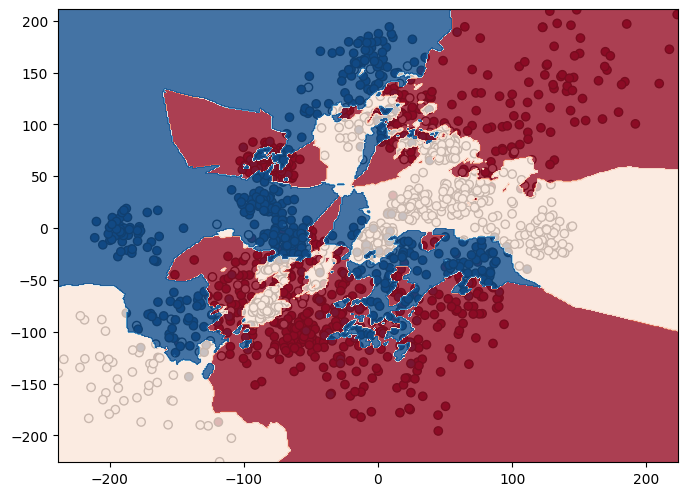

In [111]:
train_with_params(X, y, 4, 'uniform', 'mahalanobis')

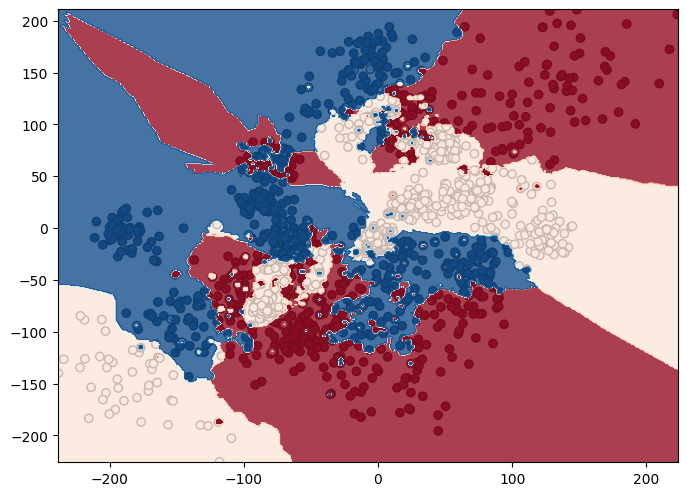

In [110]:
train_with_params(X, y, 9, 'distance')

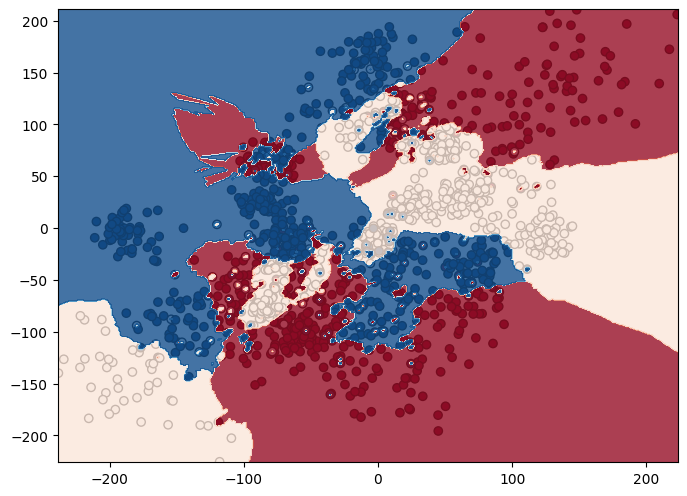

In [114]:
train_with_params(X, y, 13, 'distance', 'mahalanobis')

In [100]:
def assess_method(X, y, weights = "uniform", metric = "minkowski"):
    accuracy_best_k = []
    REPEATS_PER_K = 10
    REPEATS = 10

    for i in range(REPEATS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        accuracy_per_k = []

        for k in range(1, 21):
            accuracy = 0

            for j in range(REPEATS_PER_K):
                X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.2)
                neigh = train(X_train_1, y_train_1, k, weights, metric)
                y_predicted = neigh.predict(X_train_2)
                current_accuracy = np.sum(y_predicted == y_train_2) / y_predicted.shape[0]
                accuracy += current_accuracy

            accuracy /= REPEATS_PER_K
            # print(f"k = {k}, accuracy = {accuracy}")
            accuracy_per_k.append(accuracy)


        best_k = np.argmax(accuracy_per_k) + 1
        neigh = train(X_train, y_train, best_k, weights, metric)
        y_predicted = neigh.predict(X_test)
        current_accuracy = np.sum(y_predicted == y_test) / y_predicted.shape[0]
        accuracy_best_k.append(current_accuracy)

    print(accuracy_best_k)
    print(np.mean(accuracy_best_k))
    print(np.std(accuracy_best_k))

In [116]:
assess_method(X, y)

[0.75, 0.7733333333333333, 0.7533333333333333, 0.7633333333333333, 0.74, 0.7766666666666666, 0.8066666666666666, 0.7466666666666667, 0.78, 0.73]
0.7619999999999999
0.021509687739868902


In [117]:
assess_method(X, y, 'distance', 'mahalanobis')

[0.7533333333333333, 0.72, 0.75, 0.74, 0.76, 0.7266666666666667, 0.7433333333333333, 0.7533333333333333, 0.7133333333333334, 0.7566666666666667]
0.7416666666666667
0.01550985349884245
